# Initialization

In [1]:
from datetime import datetime
from pathlib import Path
import pickle

rebuild_labels = False
rebuild_processed = False
rebuild_data = False
rebuild_features = False
rebuild_results = False

classAttribute = 'flow_marked'
raw_dir = Path(r'C:\Users\ldeelen\Downloads\Notebooks\raw')
labels_dir = Path(r'C:\Users\ldeelen\Downloads\Notebooks\labels')
processed_dir = Path(r'C:\Users\ldeelen\Downloads\Notebooks\processed')
cache_dir = Path(r'C:\Users\ldeelen\Downloads\Notebooks\cache')

def RebuildDirectory(dir):
    dir.mkdir(parents=True, exist_ok=True)
    for item in dir.iterdir():
        if item.is_dir():
            rmdir(item)
        else:
            item.unlink()

# Label Data

In [2]:
if rebuild_labels:
    RebuildDirectory(labels_dir)
    rebuild_processed = True

# Find unlabeled files
cache = [file.stem for file in labels_dir.glob("*.pcap")]
unlabeled = [file for file in raw_dir.glob("*.pcap") if file.stem not in cache]
del cache

if unlabeled:
    # List all unlabeled files in file
    pcap_list = Path('pcap_list')
    with pcap_list.open(mode='w') as f:
        for file in unlabeled:
            f.write(str(file) + '\n')
        # BUG WORKAROUND:
        # Snort does not output a log for the final PCAP in the --pcap-file list,
        # yet still processes the file. Duplicating the last file in the list
        # gives a valid PCAP which can safely be ignored
        f.write(str(unlabeled[-1:][0]))

    # Run Snort IDS to 'label' / filter malicious packets
    snort_exe = Path(r'C:\Snort\bin\snort.exe')
    snort_config = Path(r'C:\Snort\etc\snort.conf')
    done = False
    while not done:
        result = ! $snort_exe -q --pcap-reset -c $snort_config -l $labels_dir --pcap-file $pcap_list
        done = 'Fatal Error, Quitting..' not in result
    
    # Rename Snort output
    for (pcap, detection) in zip(unlabeled, labels_dir.glob("*.log*")):
        detection.rename(labels_dir / pcap.name)

    # Clean up
    del snort_exe, snort_config
    pcap_list.unlink()
    for file in labels_dir.glob("*.ids"):
        file.unlink()

del unlabeled

# Generate Features

### Initialization

In [3]:
if rebuild_processed:
    RebuildDirectory(processed_dir)
    rebuild_data = True

# Find unprocesed files
cache = [file.stem for file in processed_dir.glob("*.csv")]
unprocessed = [(raw_dir / file.name, labels_dir / file.name) for file in raw_dir.glob("*.pcap") if file.stem not in cache]
del cache

# If processing is needed, load all helpers
if(unprocessed):
    from scapy.all import *
    from scipy.stats import scoreatpercentile
    from statistics import mean, median, stdev, variance
    
    class Flow:
        def __init__(self, proto, src, sport, dst, dport):
            self.proto = proto
            self.src = src
            self.sport = sport
            self.dst = dst
            self.dport = dport
            self.trace = PacketList()
            self.features = {}
            self.marked = False

        def isA(self, pkt):
            if 'IP' in pkt:
                return pkt[IP].src == self.src
            elif 'IPv6' in pkt:
                return pkt[IPv6].src == self.src
            else:
                return False

        def isB(self, pkt):
            if 'IP' in pkt:
                return pkt[IP].src == self.dst
            elif 'IPv6' in pkt:
                return pkt[IPv6].src == self.dst
            else:
                return False

    class Conversation:
        def __init__(self, src, dst):
            self.src = src
            self.dst = dst
            self.flows = {}
            self.features = {}
            self.marked = False

    def FlowTupleOf(pkt):    
        proto, src, sport, dst, dport = None, None, None, None, None

        try:
            if 'UDP' in pkt: proto = 'UDP'
            if 'TCP' in pkt: proto = 'TCP'
            if 'IP' in pkt:
                src = pkt[IP].src
                dst = pkt[IP].dst
                sport = pkt[IP].sport
                dport = pkt[IP].dport
            elif 'IPv6' in pkt:
                src = pkt[IPv6].src
                dst = pkt[IPv6].dst
                sport = pkt[IPv6].sport
                dport = pkt[IPv6].dport
        except:
            #pkt.show()
            pass

        return proto, src, sport, dst, dport

    def CombineTraces(a, b):
        return PacketList( sorted((a + b), key = lambda x:x.time) )

    def RecordStatsOf(features, prefix, data):
        features[prefix + '_avg'] = mean(data) if data else 0
        features[prefix + '_firstQ'] = scoreatpercentile(data, 25) if data else 0
        features[prefix + '_max'] = max(data) if data else 0
        features[prefix + '_median'] = median(data) if data else 0
        features[prefix + '_min'] = min(data) if data else 0
        features[prefix + '_stdev'] = stdev(data) if len(data) > 1 else 0
        features[prefix + '_sum'] = sum(data) if data else 0
        features[prefix + '_thirdQ'] = scoreatpercentile(data, 75) if data else 0
        features[prefix + '_var'] = variance(data) if len(data) > 1 else 0

### PCAP Processing

In [4]:
for (raw_pcap, label_pcap) in unprocessed:
    rebuild_data = True
    
    # Load pcaps
    raw_data = rdpcap(str(raw_pcap))
    label_data = rdpcap(str(label_pcap))
    
    # Use NIC timestamp on receival for matching
    marked_times = set([pkt.time for pkt in label_data])
    
    # Split pcap into sessions for easy processing
    sessions = raw_data.sessions()
    Conversations = {}
    for key, session in sessions.items():
        # Filter out ARP and ICMP traffic
        if 'ARP' in key or ('IPv6' in key and session[0]['IPv6'].nh is 58) or 'ICMP' in key:
            continue
            
        proto, src, sport, dst, dport = FlowTupleOf(session[0])
        if proto is None or src is None or sport is None or dst is None or dport is None:
            continue
        
        # Find or add the corresponding Conversation
        conv, newConv, extConv = None, f'{src} > {dst}', f'{dst} > {src}'
        if newConv in Conversations: conv = Conversations[newConv]
        if extConv in Conversations: conv = Conversations[extConv]
        if conv is None: conv = Conversations[newConv] = Conversation(src, dst)
        
        # Find or add the corresponding Flow
        flow, newFlow, extFlow = None, f'{proto} {src}:{sport} > {dst}:{dport}', f'{proto} {dst}:{dport} > {src}:{sport}'
        if newFlow in conv.flows: flow = conv.flows[newFlow]
        if extFlow in conv.flows: flow = conv.flows[extFlow]
        if flow is None: flow = conv.flows[newFlow] = Flow(proto, src, sport, dst, dport)
        
        # Mark conversations and flows if labeled
        for pkt in session:
            if pkt.time in marked_times:
                conv.marked = True
                flow.marked = True
                break
        
        # Merge session if it was matched to a flow
        flow.trace = CombineTraces(flow.trace, session)
        
    # Generate features
    for conv_key, conv in Conversations.items():
        # Generate flow features first
        for flow_key, flow in conv.flows.items():
            flow.features['flow_marked'] = int(flow.marked)
            flow.features['flow_ack'] = len([1 for pkt in flow.trace if pkt[TCP].ack > 0]) if flow.proto == 'TCP' else 0
            flow.features['flow_ack_A'] = len([1 for pkt in flow.trace if pkt[TCP].ack > 0 and flow.isA(pkt)]) if flow.proto == 'TCP' else 0
            flow.features['flow_ack_B'] = len([1 for pkt in flow.trace if pkt[TCP].ack > 0 and flow.isB(pkt)]) if flow.proto == 'TCP' else 0
            flow.features['flow_bidirectional'] = int(any((1 for pkt in flow.trace if pkt.src == flow.dst)))
            RecordStatsOf(flow.features, 'flow_bytes', [len(pkt) for pkt in flow.trace])
            RecordStatsOf(flow.features, 'flow_bytes_A', [len(pkt) for pkt in flow.trace if flow.isA(pkt)])
            RecordStatsOf(flow.features, 'flow_bytes_B', [len(pkt) for pkt in flow.trace if flow.isB(pkt)])
            flow.features['flow_bytes_A_B_ratio'] = flow.features['flow_bytes_A_sum'] / flow.features['flow_bytes_B_sum'] if flow.features['flow_bytes_B_sum'] else 0
            RecordStatsOf(flow.features, 'flow_dns_count_addresses', [pkt.arcount + pkt.ancount + pkt.nscount for pkt in flow.trace if LLMNRResponse in pkt])
            RecordStatsOf(flow.features, 'flow_dns_count_additional_records', [pkt.arcount for pkt in flow.trace if LLMNRResponse in pkt])
            RecordStatsOf(flow.features, 'flow_dns_count_answer_records', [pkt.ancount for pkt in flow.trace if LLMNRResponse in pkt])
            RecordStatsOf(flow.features, 'flow_dns_count_authoritative_records', [pkt.nscount for pkt in flow.trace if LLMNRResponse in pkt])
            RecordStatsOf(flow.features, 'flow_dns_ttl', list(itertools.chain(*[[rec.ttl for rec in pkt[LLMNRResponse].an] for pkt in flow.trace if LLMNRResponse in pkt])))
            RecordStatsOf(flow.features, 'flow_dns_errors', [pkt[LLMNRResponse].rcode for pkt in flow.trace if LLMNRResponse in pkt])
            flow.features['flow_duration'] = max([pkt.time for pkt in flow.trace]) - min([pkt.time for pkt in flow.trace])
            flow.features['flow_packets'] = len(flow.trace)
            flow.features['flow_packets_A'] = len([1 for pkt in flow.trace if flow.isA(pkt)])
            flow.features['flow_packets_B'] = len([1 for pkt in flow.trace if flow.isB(pkt)])
            flow.features['flow_packets_A_B_ratio'] = flow.features['flow_packets_A'] / flow.features['flow_packets_B'] if flow.features['flow_packets_B'] else 0
            flow.features['flow_push'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x08]) if flow.proto == 'TCP' else 0
            flow.features['flow_push_A'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x08 and flow.isA(pkt)]) if flow.proto == 'TCP' else 0
            flow.features['flow_push_B'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x08 and flow.isB(pkt)]) if flow.proto == 'TCP' else 0
            flow.features['flow_reset'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x04]) if flow.proto == 'TCP' else 0
            flow.features['flow_reset_A'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x04 and flow.isA(pkt)]) if flow.proto == 'TCP' else 0
            flow.features['flow_reset_B'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x04 and flow.isB(pkt)]) if flow.proto == 'TCP' else 0
            RecordStatsOf(flow.features, 'flow_ttl', [pkt.ttl for pkt in flow.trace] if flow.proto == 'TCP' else [])
            RecordStatsOf(flow.features, 'flow_ttl_A', [pkt.ttl for pkt in flow.trace if flow.isA(pkt)] if flow.proto == 'TCP' else [])
            RecordStatsOf(flow.features, 'flow_ttl_B', [pkt.ttl for pkt in flow.trace if flow.isB(pkt)] if flow.proto == 'TCP' else [])
            flow.features['flow_urg'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x20]) if flow.proto == 'TCP' else 0
            flow.features['flow_urg_A'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x20 and flow.isA(pkt)]) if flow.proto == 'TCP' else 0
            flow.features['flow_urg_B'] = sum([1 for pkt in flow.trace if pkt[TCP].flags & 0x20 and flow.isB(pkt)]) if flow.proto == 'TCP' else 0
            
            flow_feats = list(flow.features.keys())
        
        # Generate conversation features second
        conv.features['cw_marked'] = int(conv.marked)
        conv.features['cw_count_flows'] = len(conv.flows)
        conv.features['cw_dst_ports'] = len(set([flow.dport for flow in conv.flows.values()]))
        conv.features['cw_dst_ports_flows_ratio'] = conv.features['cw_dst_ports'] / conv.features['cw_count_flows']
        conv.features['cw_dst_ports_tcp'] = len(set([flow.dport for flow in conv.flows.values() if flow.proto == 'TCP']))
        conv.features['cw_dst_ports_udp'] = len(set([flow.dport for flow in conv.flows.values() if flow.proto == 'UDP']))
        conv.features['cw_dst_ports_tcp_udp_ratio'] = conv.features['cw_dst_ports_tcp'] / conv.features['cw_dst_ports_udp'] if conv.features['cw_dst_ports_udp'] else 0
        conv.features['cw_duration'] = max([pkt.time for pkt in flow.trace for flow in conv.flows.values()]) - min([pkt.time for pkt in flow.trace for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_bytes', [flow.features['flow_bytes_sum'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_bytes_A', [flow.features['flow_bytes_A_sum'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_bytes_B', [flow.features['flow_bytes_B_sum'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_duration', [flow.features['flow_duration'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_packets', [flow.features['flow_packets'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_packets_A', [flow.features['flow_packets_A'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_packets_B', [flow.features['flow_packets_B'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_push', [flow.features['flow_push'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_push_A', [flow.features['flow_push_A'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_push_B', [flow.features['flow_push_B'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_reset', [flow.features['flow_reset'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_reset_A', [flow.features['flow_reset_A'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_reset_B', [flow.features['flow_reset_B'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_urg', [flow.features['flow_urg'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_urg_A', [flow.features['flow_urg_A'] for flow in conv.flows.values()])
        RecordStatsOf(conv.features, 'cw_flow_urg_B', [flow.features['flow_urg_B'] for flow in conv.flows.values()])
        conv.features['cw_src_ports'] = len(set([flow.sport for flow in conv.flows.values()]))
        conv.features['cw_src_ports_flows_ratio'] = conv.features['cw_src_ports'] / conv.features['cw_count_flows']
        conv.features['cw_src_ports_tcp'] = len(set([flow.sport for flow in conv.flows.values() if flow.proto == 'TCP']))
        conv.features['cw_src_ports_udp'] = len(set([flow.sport for flow in conv.flows.values() if flow.proto == 'UDP']))
        conv.features['cw_src_ports_tcp_udp_ratio'] = conv.features['cw_src_ports_tcp'] / conv.features['cw_src_ports_udp'] if conv.features['cw_src_ports_udp'] else 0
        RecordStatsOf(conv.features, 'cw_tcp_bytes', [flow.features['flow_bytes_sum'] for flow in conv.flows.values() if flow.proto == 'TCP'])
        RecordStatsOf(conv.features, 'cw_tcp_bytes_A', [flow.features['flow_bytes_A_sum'] for flow in conv.flows.values() if flow.proto == 'TCP'])
        RecordStatsOf(conv.features, 'cw_tcp_bytes_B', [flow.features['flow_bytes_B_sum'] for flow in conv.flows.values() if flow.proto == 'TCP'])
        RecordStatsOf(conv.features, 'cw_tcp_flow_duration', [flow.features['flow_duration'] for flow in conv.flows.values() if flow.proto == 'TCP'])
        RecordStatsOf(conv.features, 'cw_tcp_packets', [flow.features['flow_packets'] for flow in conv.flows.values() if flow.proto == 'TCP'])
        RecordStatsOf(conv.features, 'cw_tcp_packets_A', [flow.features['flow_packets_A'] for flow in conv.flows.values() if flow.proto == 'TCP'])
        RecordStatsOf(conv.features, 'cw_tcp_packets_B', [flow.features['flow_packets_B'] for flow in conv.flows.values() if flow.proto == 'TCP'])
        RecordStatsOf(conv.features, 'cw_udp_bytes', [flow.features['flow_bytes_sum'] for flow in conv.flows.values() if flow.proto == 'UDP'])
        RecordStatsOf(conv.features, 'cw_udp_bytes_A', [flow.features['flow_bytes_A_sum'] for flow in conv.flows.values() if flow.proto == 'UDP'])
        RecordStatsOf(conv.features, 'cw_udp_bytes_B', [flow.features['flow_bytes_B_sum'] for flow in conv.flows.values() if flow.proto == 'UDP'])
        RecordStatsOf(conv.features, 'cw_udp_flow_duration', [flow.features['flow_duration'] for flow in conv.flows.values() if flow.proto == 'UDP'])
        RecordStatsOf(conv.features, 'cw_udp_packets', [flow.features['flow_packets'] for flow in conv.flows.values() if flow.proto == 'UDP'])
        RecordStatsOf(conv.features, 'cw_udp_packets_A', [flow.features['flow_packets_A'] for flow in conv.flows.values() if flow.proto == 'UDP'])
        RecordStatsOf(conv.features, 'cw_udp_packets_B', [flow.features['flow_packets_B'] for flow in conv.flows.values() if flow.proto == 'UDP'])
        conv.features['cw_tcp_flows'] = len([1 for flow in conv.flows.values() if flow.proto == 'TCP'])
        conv.features['cw_udp_flows'] = len([1 for flow in conv.flows.values() if flow.proto == 'UDP'])
        conv.features['cw_tcp_udp_ratio'] = conv.features['cw_tcp_flows'] / conv.features['cw_udp_flows'] if conv.features['cw_udp_flows'] else 0
                                             
        conv_feats = list(conv.features.keys())
    
    # Write all features to disk
    csv = Path(str(processed_dir / raw_pcap.stem) + '.csv')
    with csv.open(mode='w') as f:
        # Write CSV header first
        f.write(','.join(conv_feats) + ',' + ','.join(flow_feats) + '\n')
        
        # Pairwise combine conversations and flows
        for conv in Conversations.values():
            conv_values = []
            for key in conv_feats:
                conv_values.append(str(conv.features[key]))
                
            for flow in conv.flows.values():
                flow_values = []
                for key in flow_feats:
                    flow_values.append(str(flow.features[key]))
                    
                f.write(','.join(conv_values) + ',' + ','.join(flow_values) + '\n')

# Clean up
if unprocessed:
    del raw_pcap, label_pcap, raw_data, label_data, sessions, Conversations
del unprocessed

# Data Set Preparation

In [5]:
from pandas import read_csv

if rebuild_data:
    rebuild_features = True
    
    # Combine all data
    files = processed_dir.glob("*.csv")
    
    # Open output stream
    with open(cache_dir / 'data.csv', 'wb') as data:
        # Fully write first file, including header
        with open(next(files), "rb") as csv:
            data.write(csv.read())
        # Iterate over remaining files
        for file in files:
            with open(file, "rb") as csv:
                next(csv) # Skip over the header
                data.write(csv.read())
                
    del files

data = read_csv(cache_dir / 'data.csv')

positives = sum(data[classAttribute])
negatives = len(data) - positives

print(f'Number of positives: {positives}')
print(f'Number of negatives: {negatives}')
print(f'Negative imbalance: {negatives / positives:.1f}x')

del data

Number of positives: 3222
Number of negatives: 195231
Negative imbalance: 60.6x


# Feature Selection

### Initialization

In [6]:
if rebuild_features:
    rebuild_results = True
    
    from itertools import combinations
    from math import sqrt
    from statistics import mean
    
    def MaxValuePair(dictionary):
        values = list(dictionary.values())
        keys = list(dictionary.keys())
        maxVal = max(values)
        return keys[values.index(maxVal)], maxVal

    def Merit(featureSet, corrMatrix, className):
        k = len(featureSet)
        rcf = mean([corrMatrix[feat][className] for feat in featureSet])
        rff = mean([corrMatrix[a][b] for a, b in combinations(featureSet, 2)]) if k > 1 else 1
        return (k * rcf) / (sqrt(k + k * (k - 1) * rff))

    def CFS(corrMatrix, featureSet, classAttribute):
        selected = set()
        newMerit, maxMerit = 0, 0

        done = False
        while not done:
            evaluations = {feat:Merit(selected | set([feat]), corrMatrix, classAttribute) for feat in featureSet - selected}
            newFeat, newMerit = MaxValuePair(evaluations)
            if newMerit > maxMerit:
                maxMerit = newMerit
                selected |= set([newFeat])
            else:
                done = True

        return selected

### Scaling and CFS

In [7]:
#%%time
from pandas import DataFrame
from sklearn.preprocessing import minmax_scale, normalize, robust_scale, scale

scalarSet = { 'Unscaled' : (lambda x : x),
              'Min-Max' : minmax_scale,
              'Normalize' : normalize,
              'Robust' : robust_scale,
              'Scale' : scale}

corrSet = { 'Pearson' : 'pearson',
            'Kendall' : 'kendall',
            'Spearman' : 'spearman'}

# Scaling
if rebuild_features:    
    data = read_csv(cache_dir / 'data.csv')
    
    # Drop Conversation label, as it is no longer used at this point
    data.drop('cw_marked', axis=1, inplace=True)
    
    for scalarName, scalarFunc in scalarSet.items():
        with (cache_dir / f'{scalarName}_scaling').open(mode='wb') as f:
            print(f'Scaling data using {scalarName}...')
            # Drop the label to prevent distortion
            scaledData = data.drop(classAttribute, axis=1)
            # Save the column names
            columns = list(scaledData)
            # Scale and restore DataFrame
            scaledData = DataFrame(scalarFunc(scaledData))
            scaledData.columns = columns
            # Ensure original labels are preserved
            scaledData[classAttribute] = data[classAttribute]
            
            # Write data to disk
            pickle.dump(scaledData, f)
            del scaledData
    
    del data, scalarName, scalarFunc

# Correlation
if rebuild_features:    
    for scalarName in scalarSet.keys():
        with (cache_dir / f'{scalarName}_scaling').open(mode='rb') as data:
            scaledData = pickle.loads(data.read())
            
            for corrName, corrFunc in corrSet.items():
                print(f'Calculating correlation {scalarName} {corrName}... ({datetime.now().isoformat(" ", "seconds")})')
                corrMatrix = scaledData.corr(method=corrFunc)
                
                with (cache_dir / f'{scalarName}_{corrName}_correlation').open(mode='wb') as f:
                    pickle.dump(corrMatrix, f)
                
                del corrMatrix
                
            del scaledData, corrName, corrFunc
    del scalarName

# CFS
if rebuild_features:
    for scalarName in scalarSet.keys():
            for corrName in corrSet.keys():
                with (cache_dir / f'{scalarName}_{corrName}_correlation').open(mode='rb') as f:
                    corrMatrix = pickle.loads(f.read())
                    featureSet = set(corrMatrix.drop(classAttribute, axis=1).columns)

                    print(f'Extracting features...')
                    features = CFS(corrMatrix, featureSet, classAttribute)
                    print(f'Features: {features}')

                    with (cache_dir / f'{scalarName}_{corrName}_CFS').open(mode='wb') as f:
                        pickle.dump(list(features) + [classAttribute], f)
                        
                    del corrMatrix, featureSet
                
                with (cache_dir / f'{scalarName}_scaling').open(mode='rb') as data:
                    scaledData = pickle.loads(data.read())[features + [classAttribute]]
                    
                    with (cache_dir / f'{scalarName}_{corrName}_data').open(mode='wb') as f:
                        pickle.dump(scaledData, f)
                
                del scaledData
                
    del scalarName, corrName

scalarSet = list(scalarSet.keys())
corrSet = list(corrSet.keys())

for scalarName in scalarSet:
    for corrName in corrSet:
        with (cache_dir / f'{scalarName}_{corrName}_data').open(mode='rb') as f:
            print(f'{scalarName} {corrName}: {list(pickle.loads(f.read()))}\n')

# Clean up
del scalarName, corrName

Unscaled Pearson: ['flow_bytes_A_var', 'flow_bytes_min', 'flow_marked']

Unscaled Kendall: ['cw_udp_packets_A_thirdQ', 'cw_udp_packets_thirdQ', 'cw_src_ports_flows_ratio', 'flow_marked']

Unscaled Spearman: ['cw_udp_packets_A_thirdQ', 'cw_src_ports_flows_ratio', 'flow_marked']

Min-Max Pearson: ['flow_bytes_A_var', 'flow_bytes_min', 'flow_marked']

Min-Max Kendall: ['cw_udp_packets_A_thirdQ', 'cw_udp_packets_thirdQ', 'cw_src_ports_flows_ratio', 'flow_marked']

Min-Max Spearman: ['cw_udp_packets_A_thirdQ', 'cw_src_ports_flows_ratio', 'flow_marked']

Normalize Pearson: ['cw_udp_packets_A_stdev', 'cw_udp_packets_A_sum', 'flow_marked']

Normalize Kendall: ['cw_flow_bytes_stdev', 'cw_flow_duration_thirdQ', 'cw_flow_packets_A_var', 'cw_udp_packets_stdev', 'cw_udp_flows', 'cw_udp_bytes_A_var', 'flow_marked']

Normalize Spearman: ['cw_flow_bytes_stdev', 'cw_udp_packets_stdev', 'flow_marked']

Robust Pearson: ['flow_bytes_A_var', 'flow_bytes_min', 'flow_marked']

Robust Kendall: ['cw_udp_packet

# Model Learning

### Initialization

In [8]:
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if rebuild_results:
    if (cache_dir / 'knn').exists(): (cache_dir / 'knn').unlink()
    if (cache_dir / 'rf').exists(): (cache_dir / 'rf').unlink()
    if (cache_dir / 'ada').exists(): (cache_dir / 'ada').unlink()
    if (cache_dir / 'nb').exists(): (cache_dir / 'nb').unlink()
    if (cache_dir / 'svc').exists(): (cache_dir / 'svc').unlink()
    if (cache_dir / 'sgd').exists(): (cache_dir / 'sgd').unlink()

scoring = {#'Accuracy' : 'accuracy',
           #'F1' : 'f1',
           #'Precision' : 'precision',
           #'Recall' : 'recall',
           #'Jaccard' : metrics.make_scorer(metrics.jaccard_similarity_score),
           'Matthews' : metrics.make_scorer(metrics.matthews_corrcoef)}

def exploreClassifier(clf, scalarSet, corrSet, classAttribute):
    dt = datetime.now()
    result = {}

    # Test all variations scaling - correlation
    for scalarName in scalarSet:
        result[scalarName] = {}
        for corrName in corrSet:
            print(f'Exploring: {scalarName} {corrName}\nTIME: {datetime.now().isoformat(" ", "seconds")} ({datetime.now() - dt})')
            
            # Load values from disk and clear memory
            with (cache_dir / f'{scalarName}_{corrName}_data').open(mode='rb') as f:
                  df = pickle.loads(f.read())
            X = df.drop(classAttribute, axis=1)
            y = df[classAttribute]
            del df
            
            # Fit and store results
            clf.fit(X, y)
            result[scalarName][corrName] = {'best_params_': dict(clf.best_params_),
                                            'best_estimator_': clf.best_estimator_,
                                            'best_score_': clf.best_score_,
                                            'cv_results_': clf.cv_results_,
                                            'y_pred': clf.predict(X),
                                            'y_pred_proba': clf.predict_proba(X) if hasattr(clf, 'predict_proba') else []}
            del X, y
            
    print(f'Finished: {datetime.now()} ({datetime.now() - dt})')
    del scalarName, corrName, dt
    return result

def plotResults(results, x_var, y_var, z_var=None, title='', xlabel='', ylabel='', xticks=[], yticks=[]):
    # Correct labeling
    x_var = 'param_' + x_var
    if z_var == None:
        y_var = 'mean_test_' + y_var
    else:
        y_var = 'param_' + y_var
        z_var = 'mean_test_' + z_var

    # Setup plot
    rows = len(results)
    cols = len(list(results.values())[0])
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True, figsize=(12, 8))
    if z_var == None:
        plt.ylim(-1, 1)
        
    # Loop over all results
    row = 0
    for scalarName, corrSet in results.items():
        column = 0
        for corrName, clf in corrSet.items():
            result = ( DataFrame(clf['cv_results_']) ).filter(regex='param_.*|mean_test_.*')
                  
            # For 2d plots
            if z_var == None:
                # Plot the graph
                axes[row, column].plot(result[x_var], result[y_var])

                # Add annotation with best result
                i = np.absolute(result[y_var]).max()
                i = np.where(np.absolute(result[y_var]) == i)[0][0]
                xmax = result[x_var][i]
                ymax = result[y_var][i]
                axes[row, column].text(.01, .01, 'Best:{:.4f} ({}={:d})'.format(ymax, xlabel, xmax),
                                       ha='left', va='bottom', transform=axes[row, column].transAxes)
            # For 3d plots
            else:
                # Extract data from results
                xlabels = np.unique(result[x_var])
                ylabels = np.unique(result[y_var])
                vals = np.array(result[z_var]).reshape((len(xlabels), len(ylabels)))
                
                # Plot the graph
                im = axes[row, column].imshow(vals, cmap='brg', aspect='auto', vmin=-1, vmax=1)

                # Add annotation with best result
                xmax = list(clf['best_params_'].values())[0]
                ymax = list(clf['best_params_'].values())[1]
                zmax = clf['best_score_']
                axes[row, column].text(.01, .01, 'Best:{:.4f} ({}={:d}; {}={:d})'.format(zmax, xlabel, xmax, ylabel, ymax),
                                       ha='left', va='bottom', transform=axes[row, column].transAxes)

            column += 1
        row += 1

    # Add labels
    fig.suptitle(title, fontsize=16)
    
    for ax, col in zip(axes[0], yticks):
        ax.set_title(f'{col} correlation')
        
    for ax, row in zip(axes[:,0], xticks):
        ax.annotate(row, xy=(-.3, .5), xycoords=ax.transAxes,
                    size='large', ha='right', va='center')
        
    for ax in axes[-1]:
        ax.set_xlabel(xlabel)

    for ax, row in zip(axes[:,0], xticks):
        ax.set_ylabel(ylabel)
        
    if not z_var == None:
        fig.colorbar(im, ax=axes.ravel().tolist())

    plt.show()

def heatmapResults(results, x_var, title='', xticks=[], yticks=[]):
    # Extract data from results
    x_var = 'mean_test_' + x_var
    vals = [ [ ( DataFrame(corr['cv_results_']) ).filter(regex='param_.*|mean_test_.*')[x_var][0] for corr in scalar.values() ] for scalar in results.values() ]
    
    # Setup plot
    fig, ax = plt.subplots(figsize=(12, 8))
    # Plot results
    im = ax.imshow(vals, cmap='brg', aspect='auto', vmin=-1, vmax=1)
    # Add labels
    fig.suptitle(title, fontsize=16)
    ax.set_xticks(range(len(xticks)))
    ax.set_yticks(range(len(yticks)))
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(yticks)
    fig.colorbar(im, ax=ax)
    
    # Show values
    for i in range(len(vals)):
        for j in range(len(vals[i])):
            text = ax.text(j, i, '{:.4f}'.format(vals[i][j]),
                           ha="center", va="center", color="black")
    plt.show()

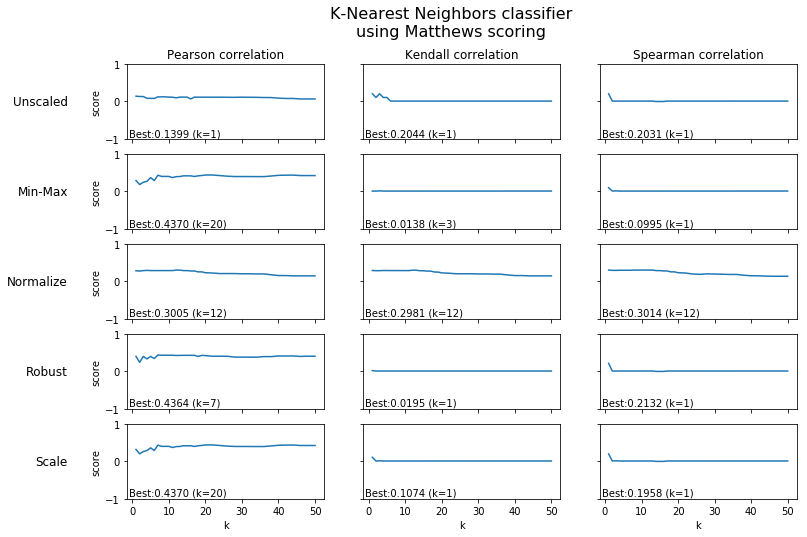

In [9]:
### K-Nearest Neighbors ###
if not (cache_dir / 'knn').exists():
    from sklearn.neighbors import KNeighborsClassifier
    
    clf = GridSearchCV(estimator = KNeighborsClassifier(),
                   param_grid = {'n_neighbors' : [*range(1, 21), *range(22, 51, 2)]},
                   scoring = scoring,
                   n_jobs = -2,
                   cv = 10,
                   verbose = 1,
                   refit = 'Matthews',
                   error_score = 0,
                   return_train_score = False)
    
    results = exploreClassifier(clf, scalarSet, corrSet, classAttribute)
    with (cache_dir / 'knn').open(mode='wb') as f:
        pickle.dump(results, f)
    del results

with (cache_dir / 'knn').open(mode='rb') as f:
    results = pickle.loads(f.read())
plotResults(results, 'n_neighbors', 'Matthews', title='K-Nearest Neighbors classifier\nusing Matthews scoring', xlabel='k', ylabel='\nscore', xticks=scalarSet, yticks=corrSet)
del results

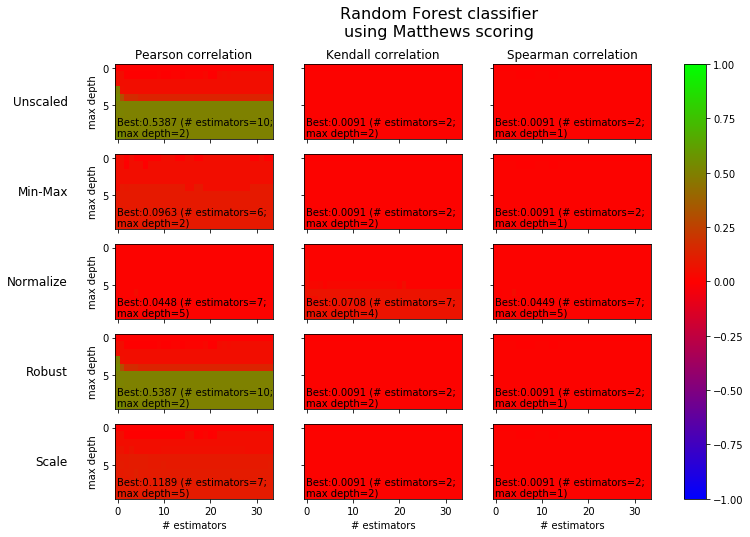

In [10]:
### Random Forest ###
if not (cache_dir / 'rf').exists():
    from sklearn.ensemble import RandomForestClassifier

    clf = GridSearchCV(estimator = RandomForestClassifier(random_state=0),
                       param_grid = {'n_estimators' : [*range(1, 11), *range(12, 31, 2), *range(35, 101, 5)], 'max_depth' : range(1, 11)},
                       scoring = scoring,
                       n_jobs = -2,
                       cv = 10,
                       verbose = 1,
                       refit = 'Matthews',
                       error_score = 0,
                       return_train_score = False)
    
    results = exploreClassifier(clf, scalarSet, corrSet, classAttribute)
    with (cache_dir / 'rf').open(mode='wb') as f:
        pickle.dump(results, f)
    del results

with (cache_dir / 'rf').open(mode='rb') as f:
    results = pickle.loads(f.read())
plotResults(results, 'max_depth', 'n_estimators', 'Matthews', title='Random Forest classifier\nusing Matthews scoring', xlabel='# estimators', ylabel='\nmax depth', xticks=scalarSet, yticks=corrSet)
del results

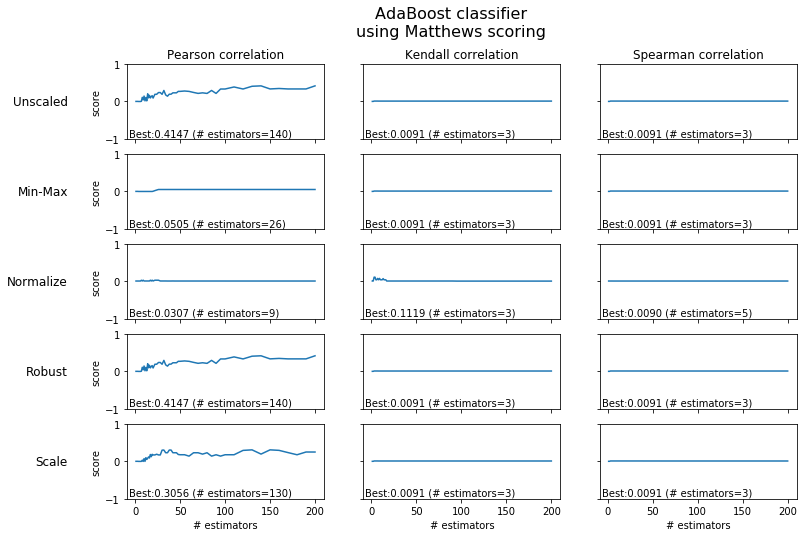

In [11]:
### AdaBoost ###
if not (cache_dir / 'ada').exists():
    from sklearn.ensemble import AdaBoostClassifier

    clf = GridSearchCV(estimator = AdaBoostClassifier(random_state=0),
                       param_grid = {'n_estimators' : [*range(1, 21), *range(22, 51, 2), *range(55, 101, 5), *range(110, 201, 10)]},
                       scoring = scoring,
                       n_jobs = -2,
                       cv = 10,
                       verbose = 1,
                       refit = 'Matthews',
                       error_score = 0,
                       return_train_score = False)
    
    results = exploreClassifier(clf, scalarSet, corrSet, classAttribute)
    with (cache_dir / 'ada').open(mode='wb') as f:
        pickle.dump(results, f)
    del results

with (cache_dir / 'ada').open(mode='rb') as f:
    results = pickle.loads(f.read())
plotResults(results, 'n_estimators', 'Matthews', title='AdaBoost classifier\nusing Matthews scoring', xlabel='# estimators', ylabel='\nscore', xticks=scalarSet, yticks=corrSet)
del results

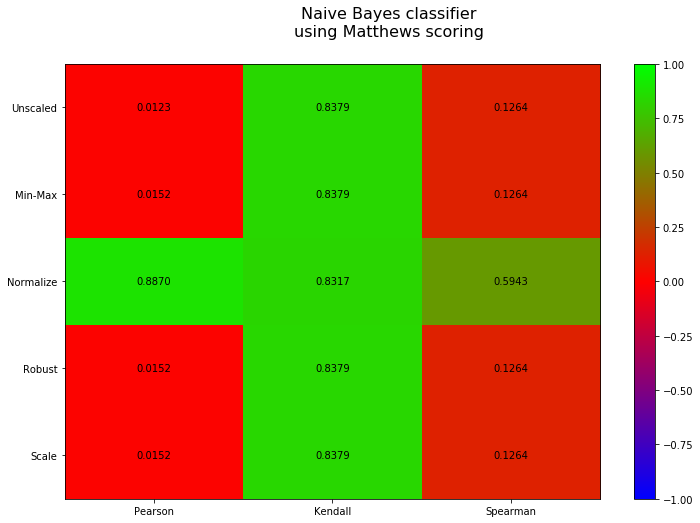

In [12]:
### Naive Bayes ###
if not (cache_dir / 'nb').exists():
    from sklearn.naive_bayes import GaussianNB

    clf = GridSearchCV(estimator = GaussianNB(),
                       param_grid = {'var_smoothing' : np.array([1e-9])},
                       scoring = scoring,
                       n_jobs = -2,
                       cv = 10,
                       verbose = 1,
                       refit = 'Matthews',
                       error_score = 0,
                       return_train_score = False)
    
    results = exploreClassifier(clf, scalarSet, corrSet, classAttribute)
    with (cache_dir / 'nb').open(mode='wb') as f:
        pickle.dump(results, f)
    del results

with (cache_dir / 'nb').open(mode='rb') as f:
    results = pickle.loads(f.read())
heatmapResults(results, 'Matthews', title='Naive Bayes classifier\nusing Matthews scoring', xticks=corrSet, yticks=scalarSet)
del results

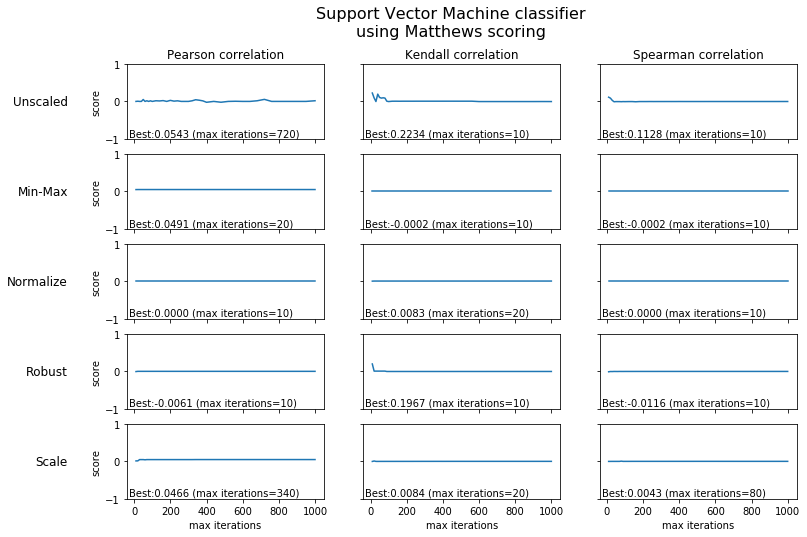

In [13]:
### Linear SVC ###
if not (cache_dir / 'svc').exists():
    from sklearn.svm import LinearSVC

    clf = GridSearchCV(estimator = LinearSVC(random_state=0),
                       param_grid = {'max_iter' : [*range(10, 101, 10), *range(120, 401, 20), *range(440, 801, 40), *range(850, 1001, 50)]},
                       scoring = scoring,
                       n_jobs = -2,
                       cv = 10,
                       verbose = 1,
                       refit = 'Matthews',
                       error_score = 0,
                       return_train_score = False)
    
    results = exploreClassifier(clf, scalarSet, corrSet, classAttribute)
    with (cache_dir / 'svc').open(mode='wb') as f:
        pickle.dump(results, f)
    del results

with (cache_dir / 'svc').open(mode='rb') as f:
    results = pickle.loads(f.read())
plotResults(results, 'max_iter', 'Matthews', title='Support Vector Machine classifier\nusing Matthews scoring', xlabel='max iterations', ylabel='\nscore', xticks=scalarSet, yticks=corrSet)
del results

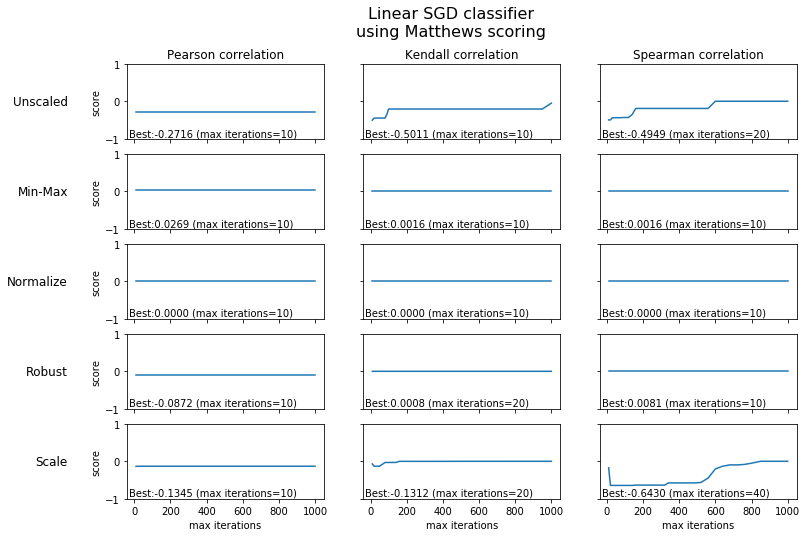

In [14]:
### Linear SGD ###
if not (cache_dir / 'sgd').exists():
    from sklearn.linear_model import SGDClassifier

    clf = GridSearchCV(estimator = SGDClassifier(random_state=0, tol=0.0001, shuffle=False, loss='squared_hinge'),
                       param_grid = {'max_iter' : [*range(10, 101, 10), *range(120, 401, 20), *range(440, 801, 40), *range(850, 1001, 50)]},
                       scoring = scoring,
                       n_jobs = -2,
                       cv = 10,
                       verbose = 1,
                       refit = 'Matthews',
                       error_score = 0,
                       return_train_score = False)
    
    results = exploreClassifier(clf, scalarSet, corrSet, classAttribute)
    with (cache_dir / 'sgd').open(mode='wb') as f:
        pickle.dump(results, f)
    del results

with (cache_dir / 'sgd').open(mode='rb') as f:
    results = pickle.loads(f.read())
plotResults(results, 'max_iter', 'Matthews', title='Linear SGD classifier\nusing Matthews scoring', xlabel='max iterations', ylabel='\nscore', xticks=scalarSet, yticks=corrSet)
del results

# Visualizations

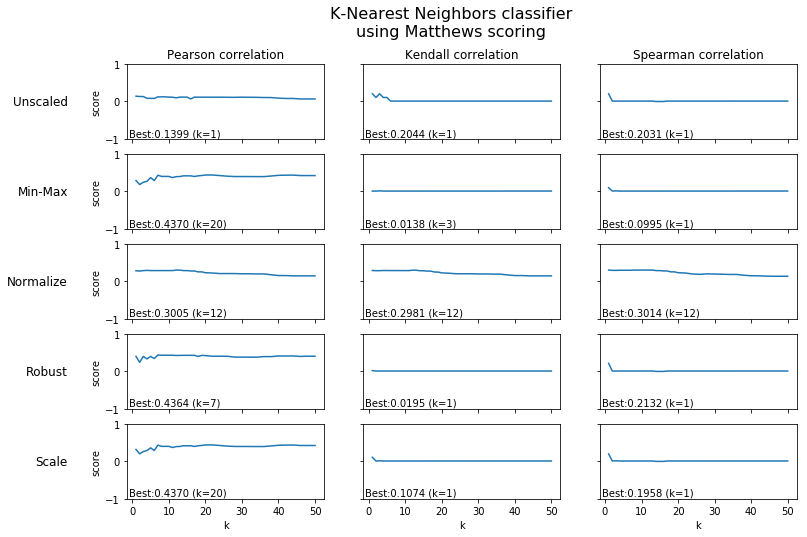

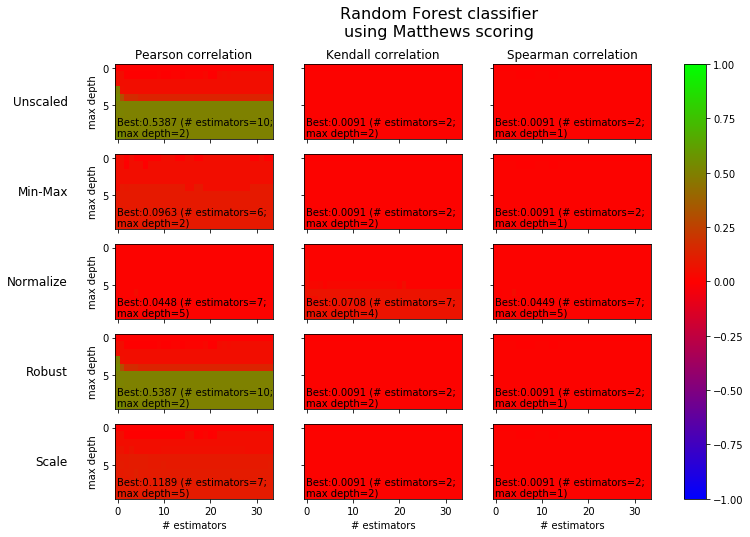

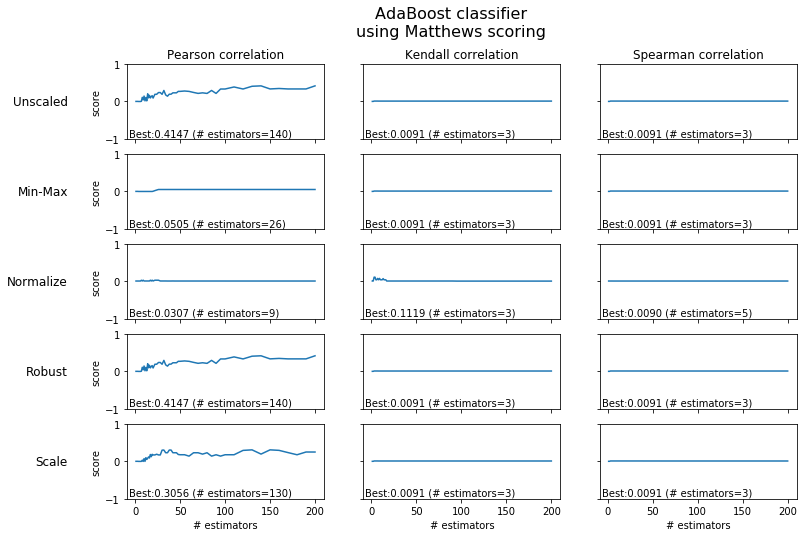

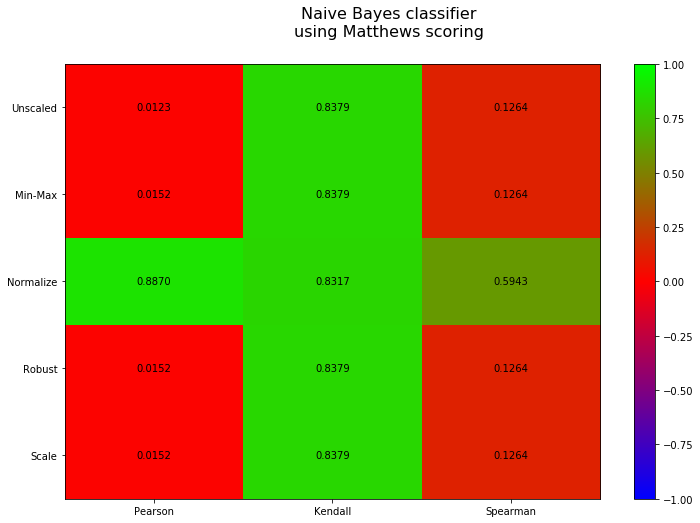

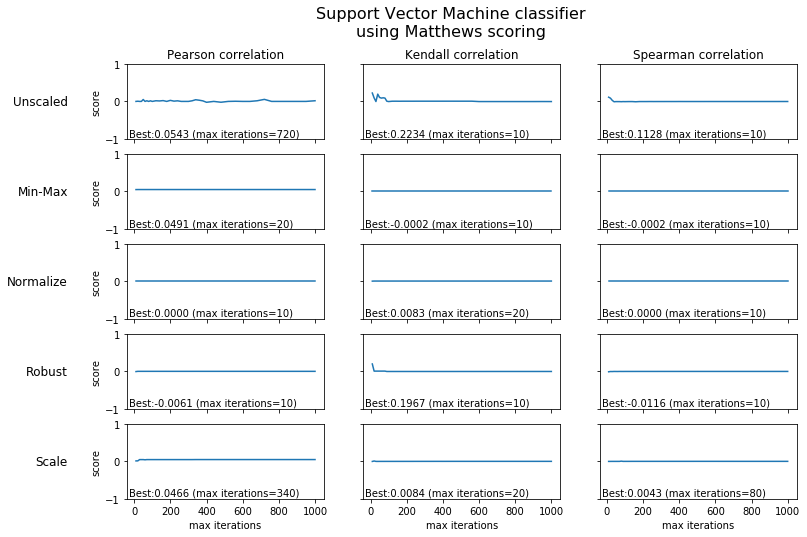

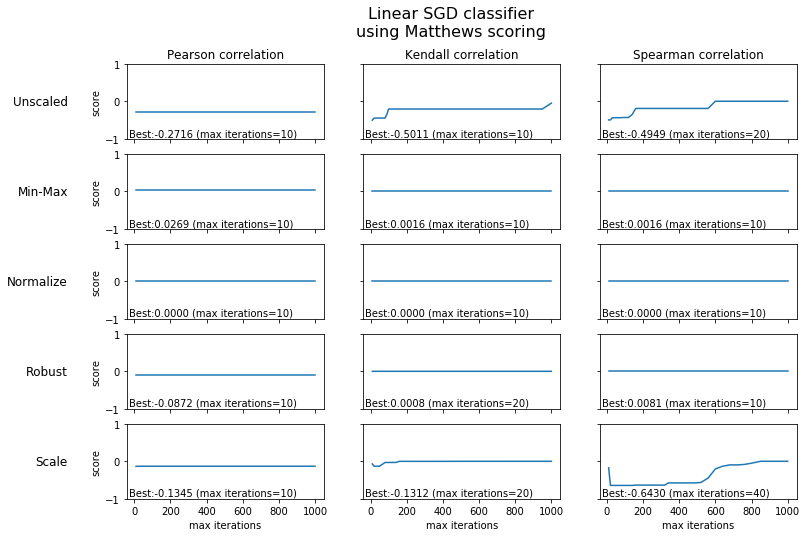

In [15]:
plotResults(pickle.loads((cache_dir / 'knn').open(mode='rb').read()), 'n_neighbors', 'Matthews', title='K-Nearest Neighbors classifier\nusing Matthews scoring', xlabel='k', ylabel='\nscore', xticks=scalarSet, yticks=corrSet)
plotResults(pickle.loads((cache_dir / 'rf').open(mode='rb').read()), 'max_depth', 'n_estimators', 'Matthews', title='Random Forest classifier\nusing Matthews scoring', xlabel='# estimators', ylabel='\nmax depth', xticks=scalarSet, yticks=corrSet)
plotResults(pickle.loads((cache_dir / 'ada').open(mode='rb').read()), 'n_estimators', 'Matthews', title='AdaBoost classifier\nusing Matthews scoring', xlabel='# estimators', ylabel='\nscore', xticks=scalarSet, yticks=corrSet)
heatmapResults(pickle.loads((cache_dir / 'nb').open(mode='rb').read()), 'Matthews', title='Naive Bayes classifier\nusing Matthews scoring', xticks=corrSet, yticks=scalarSet)
plotResults(pickle.loads((cache_dir / 'svc').open(mode='rb').read()), 'max_iter', 'Matthews', title='Support Vector Machine classifier\nusing Matthews scoring', xlabel='max iterations', ylabel='\nscore', xticks=scalarSet, yticks=corrSet)
plotResults(pickle.loads((cache_dir / 'sgd').open(mode='rb').read()), 'max_iter', 'Matthews', title='Linear SGD classifier\nusing Matthews scoring', xlabel='max iterations', ylabel='\nscore', xticks=scalarSet, yticks=corrSet)

In [16]:
### Linear SGD ###
if not (cache_dir / 'sgd_fix').exists():
    from sklearn.linear_model import SGDClassifier

    clf = GridSearchCV(estimator = SGDClassifier(random_state=0, tol=0.0001, shuffle=False, loss='squared_hinge'),
                       param_grid = {'max_iter' : [40]},
                       scoring = scoring,
                       n_jobs = -2,
                       cv = 10,
                       verbose = 1,
                       refit = 'Matthews',
                       error_score = 0,
                       return_train_score = False)
    
    results = exploreClassifier(clf, scalarSet, corrSet, classAttribute)
    print(results['Scale']['Spearman']['best_score_'])
    with (cache_dir / 'sgd_fix').open(mode='wb') as f:
        pickle.dump(results, f)
    del results

In [17]:
def displayConf(mat, confusion, title):
    print(title)
    for i in range(len(confusion)):
        mat[i][i] = "-"
    df = DataFrame(data=mat,
                   columns=list(confusion.keys()),
                   index=list(confusion.keys()))
    display(df)

knn = pickle.loads((cache_dir / 'knn').open(mode='rb').read())['Scale']['Pearson']
rf = pickle.loads((cache_dir / 'rf').open(mode='rb').read())['Robust']['Pearson']
ada = pickle.loads((cache_dir / 'ada').open(mode='rb').read())['Robust']['Pearson']
nb = pickle.loads((cache_dir / 'nb').open(mode='rb').read())['Normalize']['Pearson']
svc = pickle.loads((cache_dir / 'svc').open(mode='rb').read())['Unscaled']['Kendall']
sgd = pickle.loads((cache_dir / 'sgd_fix').open(mode='rb').read())['Scale']['Spearman']
    
confusion = {'knn': knn,
             'rf': rf,
             'ada': ada,
             'nb': nb,
             'svc': svc,
             'sgd': sgd
            }
y = read_csv(cache_dir / 'data.csv')[classAttribute].values

for name, clf in confusion.items():
    tp = sum(clf['y_pred'][y == 1] == 1)
    fp = sum(clf['y_pred'][y == 0] == 1)
    fn = sum(clf['y_pred'][y == 1] == 0)
    tn = sum(clf['y_pred'][y == 0] == 0)
    df = DataFrame(data=[[tp, fp],[fn, tn]], index=['P_pred', 'N_pred'], columns=['P_true', 'N_true'])
    print(name)
    display(df)

mat = []
for clf in confusion.values():
    mat.append([
        metrics.accuracy_score(y, clf['y_pred']),
        metrics.f1_score(y, clf['y_pred']),
        metrics.precision_score(y, clf['y_pred']),
        metrics.recall_score(y, clf['y_pred']),
        metrics.jaccard_similarity_score(y, clf['y_pred']),
        metrics.matthews_corrcoef(y, clf['y_pred']),
        metrics.roc_auc_score(y, clf['y_pred_proba'][:,1]) if len(clf['y_pred_proba']) > 0 else '-'
    ])
display(DataFrame(data=mat,
              columns=['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard', 'Matthews', 'ROC AUC'],
              index=confusion.keys()))

confusion['sgd']['y_pred'] = [1 - i for i in confusion['sgd']['y_pred']]
mat = []
for clf in confusion.values():
    mat.append([
        metrics.accuracy_score(y, clf['y_pred']),
        metrics.f1_score(y, clf['y_pred']),
        metrics.precision_score(y, clf['y_pred']),
        metrics.recall_score(y, clf['y_pred']),
        metrics.jaccard_similarity_score(y, clf['y_pred']),
        metrics.matthews_corrcoef(y, clf['y_pred']),
        metrics.roc_auc_score(y, clf['y_pred_proba'][:,1]) if len(clf['y_pred_proba']) > 0 else '-'
    ])
display(DataFrame(data=mat,
              columns=['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard', 'Matthews', 'ROC AUC'],
              index=confusion.keys()))
    
print("Errors per classifier:")
for name, clf in confusion.items():
    print("{:s} - {:d}".format(name, sum(clf['y_pred'] != y)))
print()

mat = [[sum((j['y_pred'] == y) & (i['y_pred'] != y)) for i in confusion.values()] for j in confusion.values()]
displayConf(mat, confusion, "Times ROW was correct while COLUMN was incorrect:")

mat = [["{} / {}".format(sum((i['y_pred'] != y) & (j['y_pred'] != y)), min(sum(i['y_pred'] != y), sum(j['y_pred'] != y))) for i in confusion.values()] for j in confusion.values()]
displayConf(mat, confusion, "Times both ROW and COLUMN were incorrect, compared to best of the two classifiers:")

undetected = (knn['y_pred'] != y) & (rf['y_pred'] != y) & (ada['y_pred'] != y) & (nb['y_pred'] != y) & (svc['y_pred'] != y) & (sgd['y_pred'] != y)
print("Number of completely undetected samples: {:d}".format(sum(undetected)))

del confusion, mat, name, clf, undetected

knn


,P_true,N_true
P_pred,1972,5332
N_pred,1250,189899


rf


,P_true,N_true
P_pred,1674,1259
N_pred,1548,193972


ada


,P_true,N_true
P_pred,1642,1259
N_pred,1580,193972


nb


,P_true,N_true
P_pred,3161,13008
N_pred,61,182223


svc


,P_true,N_true
P_pred,3161,15148
N_pred,61,180083


sgd


,P_true,N_true
P_pred,39,174541
N_pred,3183,20690


,Accuracy,F1,Precision,Recall,Jaccard,Matthews,ROC AUC
knn,0.966833,0.374691,0.269989,0.612042,0.966833,0.392488,0.860422
rf,0.985856,0.543948,0.570747,0.519553,0.985856,0.537392,0.979636
ada,0.985694,0.536338,0.566012,0.509621,0.985694,0.529845,0.978423
nb,0.934146,0.326028,0.195498,0.981068,0.934146,0.422451,0.964504
svc,0.923362,0.293623,0.172647,0.981068,0.923362,0.394559,-
sgd,0.104453,0.000439,0.000223,0.012104,0.104453,-0.342622,-


,Accuracy,F1,Precision,Recall,Jaccard,Matthews,ROC AUC
knn,0.966833,0.374691,0.269989,0.612042,0.966833,0.392488,0.860422
rf,0.985856,0.543948,0.570747,0.519553,0.985856,0.537392,0.979636
ada,0.985694,0.536338,0.566012,0.509621,0.985694,0.529845,0.978423
nb,0.934146,0.326028,0.195498,0.981068,0.934146,0.422451,0.964504
svc,0.923362,0.293623,0.172647,0.981068,0.923362,0.394559,-
sgd,0.895547,0.234951,0.133331,0.987896,0.895547,0.342622,-


Errors per classifier:
knn - 6582
rf - 2807
ada - 2839
nb - 13069
svc - 15209
sgd - 20729

Times ROW was correct while COLUMN was incorrect:


,knn,rf,ada,nb,svc,sgd
knn,-,321,336,12282,14421,19941
rf,4096,-,32,13053,15192,20712
ada,4079,0,-,13038,15177,20712
nb,5795,2791,2808,-,2141,7682
svc,5794,2790,2807,1,-,7261
sgd,5794,2790,2822,22,1741,-


Times both ROW and COLUMN were incorrect, compared to best of the two classifiers:


,knn,rf,ada,nb,svc,sgd
knn,-,2486 / 2807,2503 / 2839,787 / 6582,788 / 6582,788 / 6582
rf,2486 / 2807,-,2807 / 2807,16 / 2807,17 / 2807,17 / 2807
ada,2503 / 2839,2807 / 2807,-,31 / 2839,32 / 2839,17 / 2839
nb,787 / 6582,16 / 2807,31 / 2839,-,13068 / 13069,13047 / 13069
svc,788 / 6582,17 / 2807,32 / 2839,13068 / 13069,-,13468 / 15209
sgd,788 / 6582,17 / 2807,17 / 2839,13047 / 13069,13468 / 15209,-


Number of completely undetected samples: 16


In [18]:
print('Using NB as P filter and RF as second opinion:')
test = np.array([rf['y_pred'][i] if nb['y_pred'][i] == 1 else 0 for i in range(len(y))])
tp = sum(test[y == 1] == 1)
fp = sum(test[y == 0] == 1)
fn = sum(test[y == 1] == 0)
tn = sum(test[y == 0] == 0)
df = DataFrame(data=[[tp, fp],[fn, tn]], index=['P_pred', 'N_pred'], columns=['P_true', 'N_true'])
display(df)

display(DataFrame(data=[[metrics.accuracy_score(y, test), metrics.f1_score(y, test), metrics.precision_score(y, test), metrics.recall_score(y, test), metrics.jaccard_similarity_score(y, test), metrics.matthews_corrcoef(y, test), '-']],
              columns=['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard', 'Matthews', 'ROC AUC'],
              index=['NB+RF']))

del test, y, tp, fp, fn, tn, df

Using NB as P filter and RF as second opinion:


,P_true,N_true
P_pred,1624,5
N_pred,1598,195226


,Accuracy,F1,Precision,Recall,Jaccard,Matthews,ROC AUC
NB+RF,0.991923,0.669553,0.996931,0.504035,0.991923,0.705953,-
